In [2]:
import concurrent.futures
import time
import requests
import pandas as pd
import json
import logging
from typing import List, Dict, Tuple
from tqdm import tqdm  # For progress tracking
import os

In [3]:

# Configuration
MAX_WORKERS = 20  # Adjust based on API rate limits (start with 3-5)
RETRIES = 3      # Number of retry attempts per batch
BASE_DELAY = 1   # Base backoff delay in seconds


In [ ]:
api_key = "" # API Here
url = "https://api.deepseek.com/v1/chat/completions"

In [ ]:
system_prompt = """
You are a classifier for bitcoin related tweets. For each tweet below:
1. Classify it as "spam", "bot" or "human".
   - Classify as "spam" the spam, phishing, promotion, "join this" or "play this" or redirecting tweets
   - Classify as "bot" for automated price updates, news bots, or repetitive patterns
   - Classify as "human" if the tweet seems like a tweet written by a human
2. Assign one emotion representing how a bitcoin investor or fan would feel reading it from [Fear, Greed, Neutral, Optimism, Pessimism, Anger, Excitement].
3. Provide sentiment score (-1 to 1) regarding how a bitcoin investor or fan would feel about this tweet.

Return JSON in format for each ID:
{
    "1":["human","Anger",0.8]
    "2":["bot","Greed",-0.6]
    ...
}
"""

In [43]:
def generate_user_prompt(
    df_batch: pd.DataFrame,
    id_column: str = "id",
    text_column: str = "text"
) -> str:
    # Validate columns exist
    if id_column not in df_batch.columns:
        raise ValueError(f"ID column '{id_column}' not found in DataFrame")
    if text_column not in df_batch.columns:
        raise ValueError(f"Text column '{text_column}' not found in DataFrame")

    prompt_lines = ["Process these tweets:\n"]
    
    for _, row in df_batch.iterrows():
        prompt_lines.append(
            f"ID: {row[id_column]}, "
            f"Text: {repr(row[text_column])}"
        )
    
    prompt_lines.append("\nReturn JSON in the specified format.")
    return "\n".join(prompt_lines)

In [44]:
headers = {
    "Authorization": f"Bearer {api_key}",
    "Content-Type": "application/json"
}

In [45]:
def process_batch(this_user_prompt):
    data = {
        "model": "deepseek-chat",
        "messages": [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": this_user_prompt}
        ],
        "temperature": 0.1,
        "type": "json_object"
        # Enable JSON mode if supported (e.g., response_format={ "type": "json_object" })
    }
    response = requests.post(url, headers=headers, json=data)
    return response.json()["choices"][0]["message"]["content"]

In [46]:

def process_batch_with_retry(batch_df: pd.DataFrame):
    """
    Process a single batch with retry logic
    """
    for attempt in range(RETRIES):
        try:
            # Generate prompt and make API call
            prompt = generate_user_prompt(batch_df)
            return batch_df, process_batch(prompt)  # Replace with your API call
            
        except Exception as e:
            if attempt == RETRIES - 1:
                print(f"Batch {batch_df['id'].tolist()[0]} failed running last attempt.")
                return batch_df, f"error: Final failure: {str(e)} on batch: {batch_df['id'].tolist()}"
            time.sleep(BASE_DELAY * (2 ** attempt))  # Exponential backoff
        print(f"Batch {batch_df['id'].tolist()[0]} failed running attempt {attempt}")


In [6]:
filename = 'sample_200k-130k_duplicates_labeled.csv'

def parallel_processor(input_df: pd.DataFrame, num):
    """
    Process DataFrame in parallel batches
    """
    # Create thread pool with rate limiting
    with concurrent.futures.ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:     
        futures = []   
        count = 0
        for chunk in input_df:
            if count >= num:
                break
            futures.append(executor.submit(process_batch_with_retry, chunk))
            count += 1
        
        # Monitor progress
        with tqdm(total=len(futures)) as pbar:
            for future in concurrent.futures.as_completed(futures):
                chunk_df, batch_result = future.result()
                json_batch_result = json.loads(batch_result.strip('```').lstrip('json').strip())
                batch_df = pd.DataFrame.from_dict(json_batch_result, orient="index", columns=["spam", "emotion", "sentiment"])
                batch_df.index = batch_df.index.astype(int) # Ensure it's int
                merged_df = chunk_df.merge(batch_df, left_on="id", right_index=True, how="left")
                write_header = not os.path.exists(filename)
                merged_df.to_csv(filename, mode='a', index=False, header=write_header)
                pbar.update(1)


In [48]:
chunksize = 100
last_id = 0
if os.path.exists(filename):
    already_done_df = pd.read_csv(filename)
    last_id = int(already_done_df["id"].iloc[-1]) + 1

input_df = pd.read_csv("sample_200k-130k_duplicates.csv", chunksize=chunksize, on_bad_lines="skip")

for _ in range(int(last_id/100)):
    next(input_df)

# Process with parallel execution
parallel_processor(input_df, 100)

already_done_df = pd.read_csv(filename)
already_done_df = already_done_df.sort_values(by="id")
already_done_df.to_csv(filename, index=False)

100%|██████████| 90/90 [06:11<00:00,  4.13s/it] 


In [49]:
already_done_df = pd.read_csv(filename)
already_done_df = already_done_df.sort_values(by="id")
already_done_df.to_csv(filename, index=False)

In [59]:
missing_ids = set(range(already_done_df["id"].min(), already_done_df["id"].max() + 1)) - set(already_done_df["id"])
missing_ids = list(missing_ids)
missing_ids.sort()
print("Missing IDs:", missing_ids)
print("Missing IDs count:", len(missing_ids))

Missing IDs: [67900, 67901, 67902, 67903, 67904, 67905, 67906, 67907, 67908, 67909, 67910, 67911, 67912, 67913, 67914, 67915, 67916, 67917, 67918, 67919, 67920, 67921, 67922, 67923, 67924, 67925, 67926, 67927, 67928, 67929, 67930, 67931, 67932, 67933, 67934, 67935, 67936, 67937, 67938, 67939, 67940, 67941, 67942, 67943, 67944, 67945, 67946, 67947, 67948, 67949, 67950, 67951, 67952, 67953, 67954, 67955, 67956, 67957, 67958, 67959, 67960, 67961, 67962, 67963, 67964, 67965, 67966, 67967, 67968, 67969, 67970, 67971, 67972, 67973, 67974, 67975, 67976, 67977, 67978, 67979, 67980, 67981, 67982, 67983, 67984, 67985, 67986, 67987, 67988, 67989, 67990, 67991, 67992, 67993, 67994, 67995, 67996, 67997, 67998, 67999, 68100, 68101, 68102, 68103, 68104, 68105, 68106, 68107, 68108, 68109, 68110, 68111, 68112, 68113, 68114, 68115, 68116, 68117, 68118, 68119, 68120, 68121, 68122, 68123, 68124, 68125, 68126, 68127, 68128, 68129, 68130, 68131, 68132, 68133, 68134, 68135, 68136, 68137, 68138, 68139, 68140,

In [61]:
input_df = pd.read_csv("sample_200k-130k_duplicates.csv", on_bad_lines="skip")
filtered_df = input_df[input_df["id"].isin(missing_ids)]
filtered_df.to_csv("temporal.csv", index=False)


In [ ]:
input_df = pd.read_csv("temporal.csv", chunksize=chunksize, on_bad_lines="skip")

# Process with parallel execution
# parallel_processor(input_df, 10)

100%|██████████| 8/8 [01:21<00:00, 10.15s/it]


In [63]:
already_done_df = pd.read_csv(filename)
already_done_df = already_done_df.sort_values(by="id")
already_done_df.to_csv(filename, index=False)

In [64]:
missing_ids = set(range(already_done_df["id"].min(), already_done_df["id"].max() + 1)) - set(already_done_df["id"])
missing_ids = list(missing_ids)
missing_ids.sort()
print("Missing IDs:", missing_ids)
print("Missing IDs count:", len(missing_ids))

Missing IDs: []
Missing IDs count: 0


In [7]:
already_done_df = pd.read_csv(filename)
emotion_distribution = already_done_df['spam'].value_counts(normalize=True) * 100
print(emotion_distribution)

spam
human    52.986082
spam     24.284490
bot      22.729429
Name: proportion, dtype: float64


In [67]:
emotion_distribution = already_done_df['emotion'].value_counts(normalize=True) * 100
print(emotion_distribution)

emotion
Neutral           35.630507
Optimism          18.527572
Greed             16.955181
Excitement         9.952391
Fear               8.503128
Anger              7.130479
Pessimism          3.278853
Regret             0.015505
Gratitude          0.003648
Mixed              0.000912
Sadness            0.000912
Disappointment     0.000912
Name: proportion, dtype: float64


In [68]:
filtered_distribution = already_done_df[already_done_df['spam'] == 'human']['emotion'].value_counts(normalize=True) * 100
print(filtered_distribution)

emotion
Optimism          27.966262
Neutral           27.756261
Excitement        13.588088
Anger             13.305792
Fear               9.393235
Pessimism          5.716499
Greed              2.232550
Regret             0.029262
Gratitude          0.006885
Mixed              0.001721
Sadness            0.001721
Disappointment     0.001721
Name: proportion, dtype: float64


In [69]:
filtered_distribution = already_done_df[already_done_df['spam'] == 'human']['emotion'].value_counts()
print(filtered_distribution)

emotion
Optimism          16247
Neutral           16125
Excitement         7894
Anger              7730
Fear               5457
Pessimism          3321
Greed              1297
Regret               17
Gratitude             4
Mixed                 1
Sadness               1
Disappointment        1
Name: count, dtype: int64


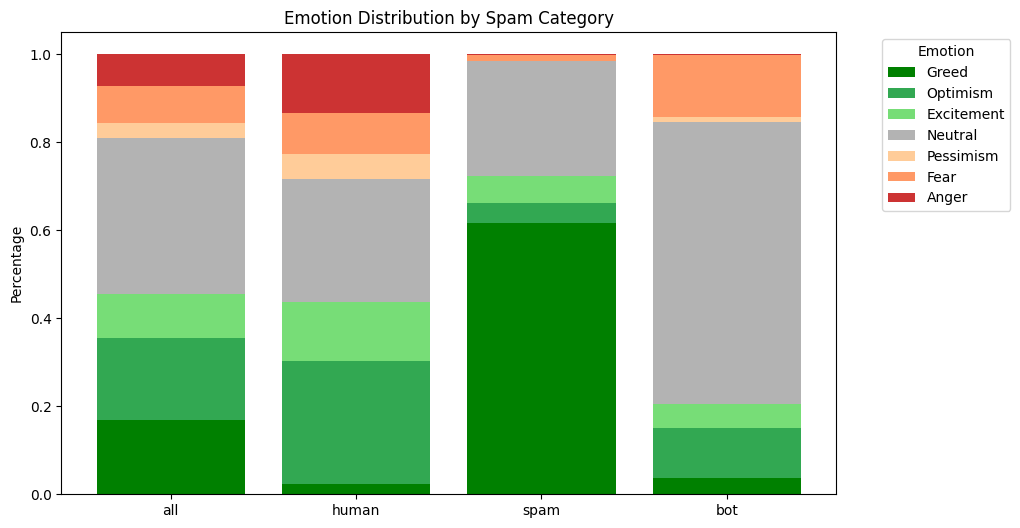

In [8]:
import matplotlib.pyplot as plt

# Define emotions sorted from better to worse
sorted_emotions = ["Greed", "Optimism", "Excitement", "Neutral", "Pessimism", "Fear", "Anger"]

# Define gradient colors
emotion_colors = {
    "Greed": "#008000",      # Strong Green (Best)
    "Optimism": "#32A852",   # Medium Green
    "Excitement": "#77DD77", # Light Green (Least Good)
    "Neutral": "#B3B3B3",    # Neutral Gray
    "Pessimism": "#FFCC99",  # Light Orange (Least Bad)
    "Fear": "#FF9966",       # Medium Orange
    "Anger": "#CC3333",      # Strong Red (Worst)
}

# Define new categories: "all" plus each spam category
spam_categories = ['all', 'human', 'spam', 'bot']
emotion_counts = {}

# Calculate emotion distribution for each spam category
for category in spam_categories:
    if category == 'all':
        # Use the entire dataframe
        df = already_done_df
    else:
        df = already_done_df[already_done_df['spam'] == category]
    
    emotion_counts[category] = df['emotion'].value_counts(normalize=True)

# Convert distributions to aligned lists for each emotion in sorted_emotions
emotion_distributions = {
    category: [emotion_counts[category].get(emotion, 0) for emotion in sorted_emotions]
    for category in spam_categories
}

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
bottom = [0] * len(spam_categories)

# Create stacked bar plots for each emotion category
for emotion in sorted_emotions:
    values = [emotion_distributions[category][sorted_emotions.index(emotion)] for category in spam_categories]
    ax.bar(spam_categories, values, bottom=bottom, label=emotion, color=emotion_colors[emotion])
    bottom = [b + v for b, v in zip(bottom, values)]

ax.set_ylabel("Percentage")
ax.set_title("Emotion Distribution by Spam Category")
ax.legend(title="Emotion", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


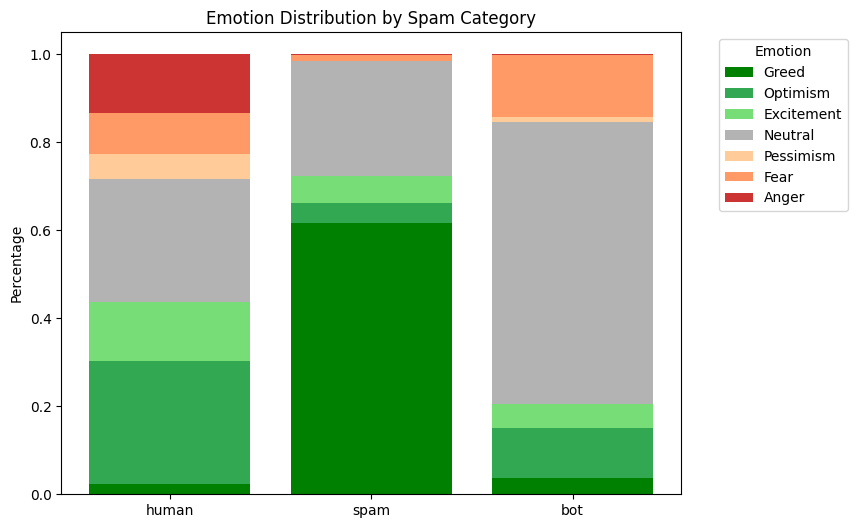

In [70]:
import matplotlib.pyplot as plt

# Define emotions sorted from better to worse
sorted_emotions = ["Greed", "Optimism", "Excitement", "Neutral", "Pessimism", "Fear", "Anger"]

# Define gradient colors
emotion_colors = {
    "Greed": "#008000",      # Strong Green (Best)
    "Optimism": "#32A852",   # Medium Green
    "Excitement": "#77DD77", # Light Green (Least Good)
    "Neutral": "#B3B3B3",    # Neutral Gray
    "Pessimism": "#FFCC99",  # Light Orange (Least Bad)
    "Fear": "#FF9966",       # Medium Orange
    "Anger": "#CC3333",      # Strong Red (Worst)
}

# Get unique spam categories
spam_categories = ['human', 'spam', 'bot']
emotion_counts = {}

# Calculate emotion distribution for each spam category
for category in spam_categories:
    emotion_counts[category] = (
        already_done_df[already_done_df['spam'] == category]['emotion']
        .value_counts(normalize=True)
    )

# Convert distributions to aligned lists
emotion_distributions = {
    category: [emotion_counts[category].get(emotion, 0) for emotion in sorted_emotions]
    for category in spam_categories
}

# Stacked bar plot
fig, ax = plt.subplots(figsize=(8, 6))

bottom = [0] * len(spam_categories)

for emotion in sorted_emotions:
    values = [emotion_distributions[category][sorted_emotions.index(emotion)] for category in spam_categories]
    ax.bar(spam_categories, values, bottom=bottom, label=emotion, color=emotion_colors[emotion])
    bottom = [b + v for b, v in zip(bottom, values)]

ax.set_ylabel("Percentage")
ax.set_title("Emotion Distribution by Spam Category")
ax.legend(title="Emotion", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


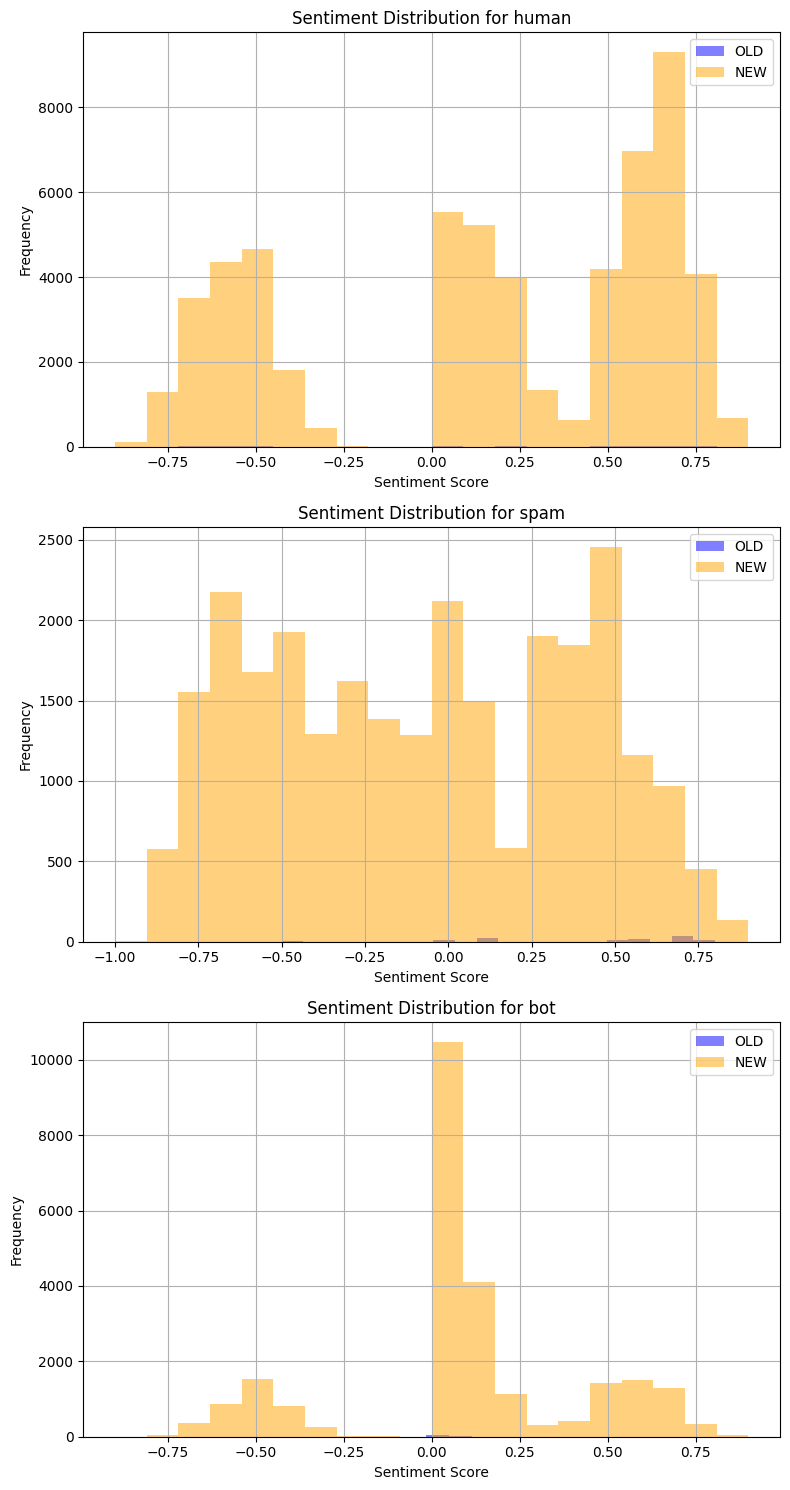

In [71]:
import matplotlib.pyplot as plt

old_df = pd.read_csv("sample_100k-64k_labeled.csv")

unique_labels = set(old_df['spam'].unique()).union(already_done_df['spam'].unique())  # Get all unique labels
fig, axes = plt.subplots(len(unique_labels), 1, figsize=(8, 5 * len(unique_labels)))

if len(unique_labels) == 1:  # Handle the case where there's only one label (avoid array indexing issues)
    axes = [axes]

for ax, label in zip(axes, unique_labels):
    old_df[old_df['spam'] == label]['sentiment'].hist(ax=ax, bins=20, alpha=0.5, label='OLD', color='blue')
    already_done_df[already_done_df['spam'] == label]['sentiment'].hist(ax=ax, bins=20, alpha=0.5, label='NEW', color='orange')
    
    ax.set_title(f'Sentiment Distribution for {label}')
    ax.set_xlabel('Sentiment Score')
    ax.set_ylabel('Frequency')
    ax.legend()

plt.tight_layout()
plt.show()
